# Data Exploration

In [1]:
#importing the needed libraries
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew

showing sample data by reading it from to file.

In [2]:
#setting the samples from the two nodes in a dataframe 
df = wfdb.rdrecord('mit-bih-arrhythmia-database-1.0.0/100').to_dataframe()
df['sample_time'] = df.index.total_seconds()
df.reset_index(inplace = True)
df.drop('index', axis = 1, inplace = True)
df

,MLII,V5,sample_time
0,-0.145,-0.065,0.000000
1,-0.145,-0.065,0.002778
2,-0.145,-0.065,0.005556
3,-0.145,-0.065,0.008333
4,-0.145,-0.065,0.011111
...,...,...,...
649995,-0.075,-0.480,1805.541161
649996,-0.445,-0.410,1805.543939
649997,-0.675,-0.365,1805.546717
649998,-0.765,-0.335,1805.549494


In [3]:
#reading annotations into a numpy array 
annotation = wfdb.rdann('mit-bih-arrhythmia-database-1.0.0/100', 'atr')
ann_symbols = np.array(annotation.symbol)
print(np.size(ann_symbols))
print(np.unique(ann_symbols, return_counts=True))

2274
(array(['+', 'A', 'N', 'V'], dtype='<U1'), array([   1,   33, 2239,    1]))


In [4]:
#reading samples as a tuple (first element is a numpy array, second is a python dictionary)
wfdb.rdsamp('mit-bih-arrhythmia-database-1.0.0/100')

(array([[-0.145, -0.065],
        [-0.145, -0.065],
        [-0.145, -0.065],
        ...,
        [-0.675, -0.365],
        [-0.765, -0.335],
        [-1.28 ,  0.   ]]),
 {'fs': 360,
  'sig_len': 650000,
  'n_sig': 2,
  'base_date': None,
  'base_time': None,
  'units': ['mV', 'mV'],
  'sig_name': ['MLII', 'V5'],
  'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']})

In [5]:
#reading the numpy array part from the tuple using sampto to limit the number of the data
record = wfdb.rdsamp('mit-bih-arrhythmia-database-1.0.0/202', sampto = 3000)
signals = record[0] 
signals.shape

(3000, 2)

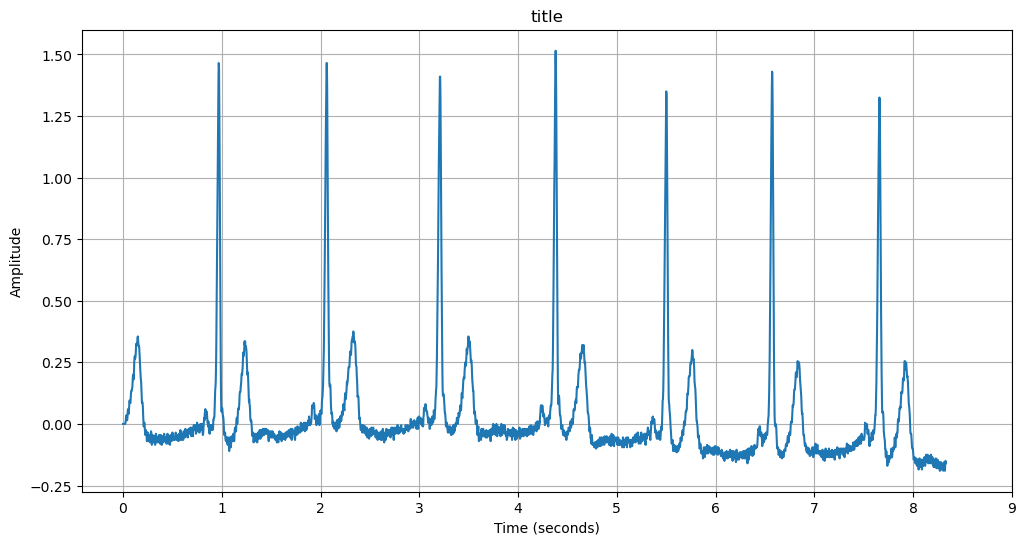

In [6]:
#Sample visualisations
time = np.arange(0, len(signals[:, 0])) / 360

plt.figure(figsize=(12, 6))
plt.plot(time,signals[:, 0])
plt.title('title')
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.xticks(np.arange(0, 10, step=1))
plt.grid(True)

In [7]:
#The list of functions of previous methods of reading the data
root_dir = "mit-bih-arrhythmia-database-1.0.0"
def get_samples(file, start = 0, n = 3000):
    file = os.path.join(root_dir, file)
    record = wfdb.rdsamp(file, sampfrom = start, sampto = start + n)
    return record

def get_dataframe(file, start = None, n = None):
    file = os.path.join(root_dir, file)
    if start == None or n == None:
        df = wfdb.rdrecord(file).to_dataframe()
    else:
        df = wfdb.rdrecord(file, sampfrom = start, sampto = start + n).to_dataframe()
    df['sample_time'] = df.index.total_seconds()
    df.reset_index(inplace = True)
    df.drop('index', axis = 1, inplace = True)
    return df

def get_annotations(file):
    file = os.path.join(root_dir, file)
    annotation = wfdb.rdann(file, 'atr')
    ann_symbols = np.array(annotation.symbol)
    return ann_symbols


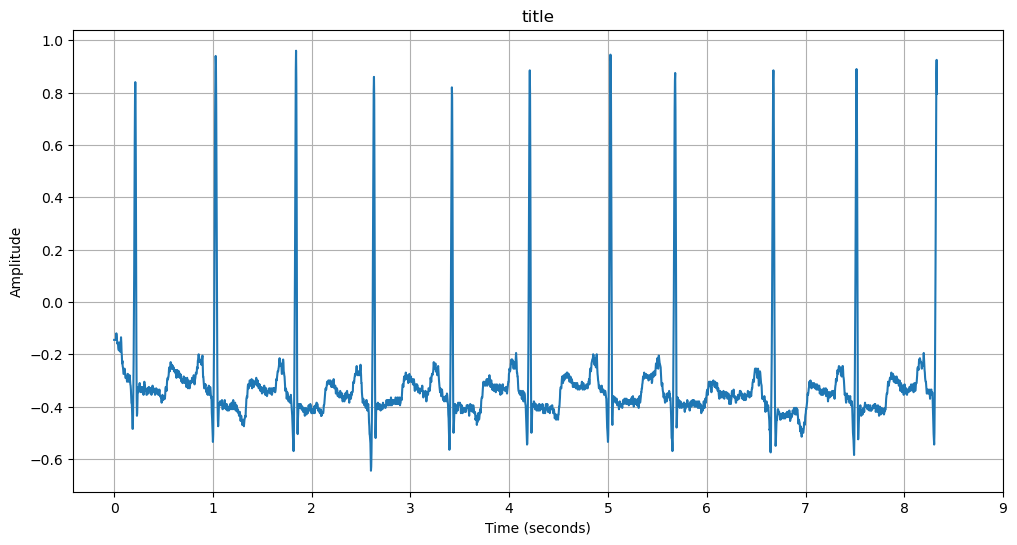

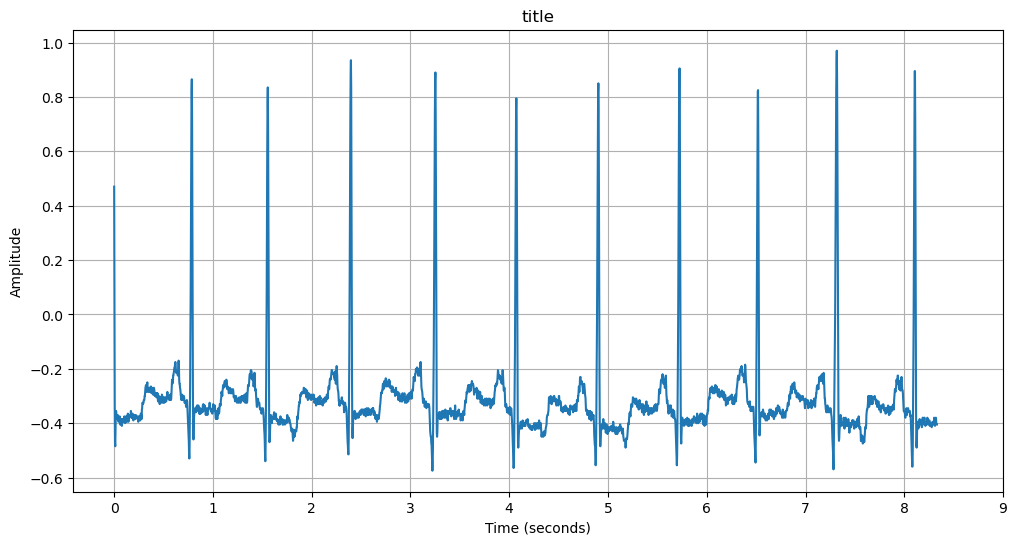

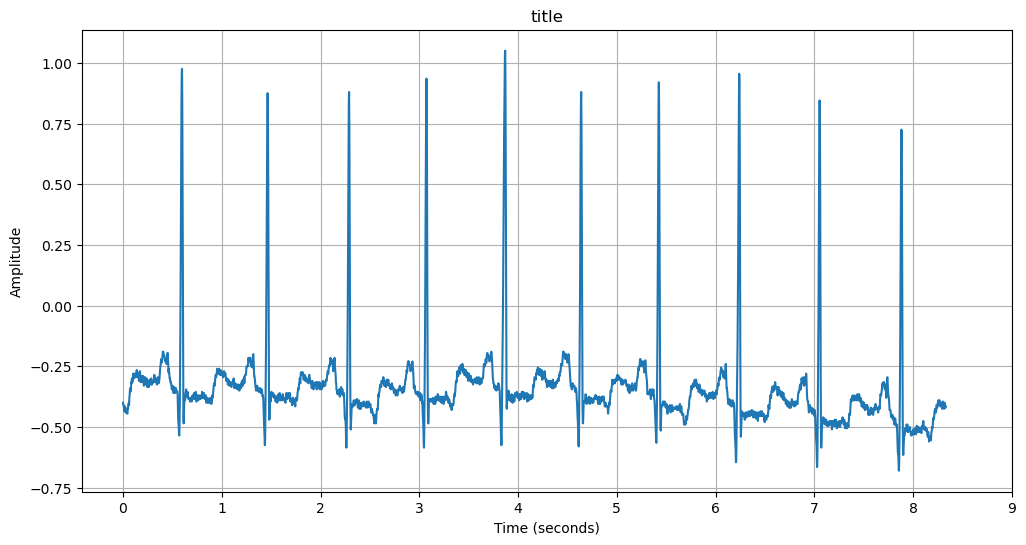

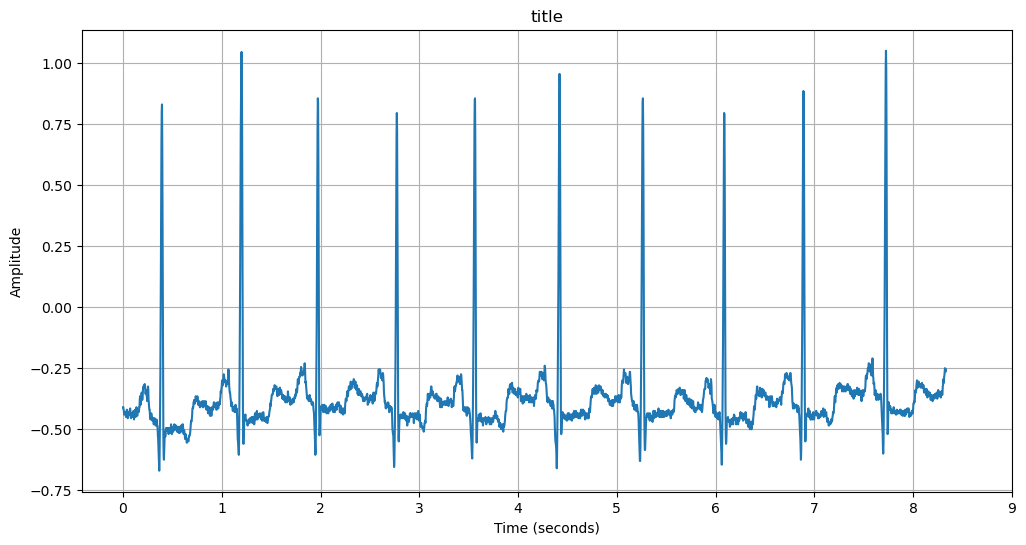

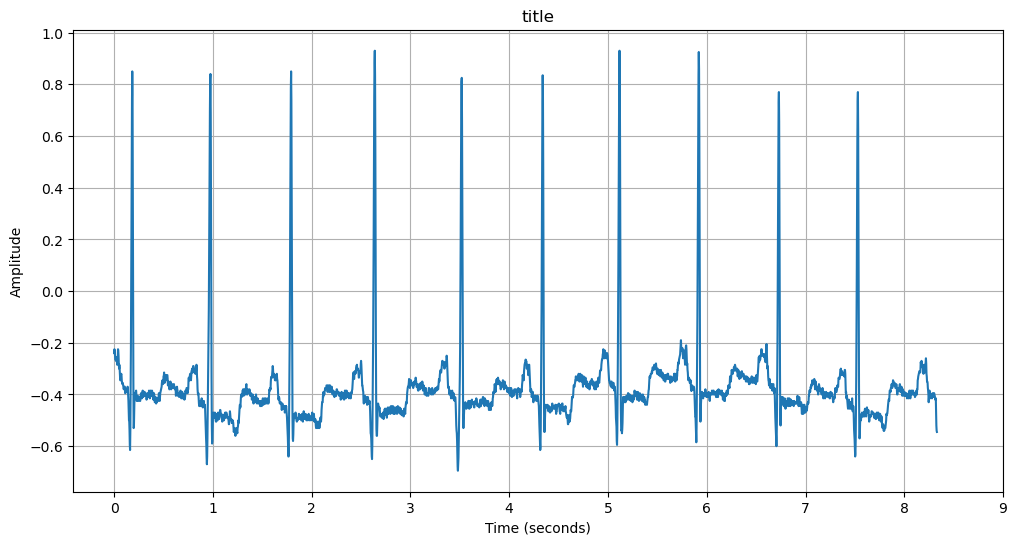

In [8]:
start = 0
for i in range(5):
    signals, titles = get_samples('100', start = start)
    start += len(signals[:, 0])
    plt.figure(figsize=(12, 6))
    plt.plot(time,signals[:, 0])
    plt.title('title')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.xticks(np.arange(0, 10, step=1))

    plt.grid(True)

# Data Extraction

Data has to be extracted from signals in time domain and frequency domain

## Time Domain

Statistical data 

### Statistical features


In [9]:
def get_statistical_data(file, batch = np.inf, start = 0, batch_size = 3000):
    batch_no = 0
    if batch != np.inf:
        size = batch
    else:
        size = int(650000 / batch_size)
    samples = np.zeros((size ,batch_size, 2))
    samples_mean = np.zeros((size, 2))
    samples_std = np.zeros((size, 2))
    samples_median = np.zeros((size, 2))
    samples_max = np.zeros((size, 2))
    samples_min = np.zeros((size, 2))
    samples_range = np.zeros((size, 2))
    samples_lower_quantile= np.zeros((size, 2))
    samples_upper_quantile= np.zeros((size, 2))
    samples_interquantile_range = np.zeros((size, 2))
    samples_kurtosis = np.zeros((size, 2))
    samples_skewness = np.zeros((size, 2))
    while True:
        try:
            samples[batch_no] = get_samples(file, start = start, n = batch_size)[0]
            samples_mean[batch_no] = np.mean(samples[batch_no], axis = 0)
            samples_std[batch_no] = np.std(samples[batch_no], axis = 0)
            samples_median[batch_no] = np.median(samples[batch_no], axis = 0)
            samples_max[batch_no] = np.max(samples[batch_no], axis = 0)
            samples_min[batch_no] = np.min(samples[batch_no], axis = 0)
            samples_range[batch_no] = np.ptp(samples[batch_no], axis = 0)
            samples_lower_quantile[batch_no] = np.quantile(samples[batch_no], 0.25)
            samples_upper_quantile[batch_no] = np.quantile(samples[batch_no], 0.75)
            samples_interquantile_range[batch_no] = samples_lower_quantile[batch_no] - samples_upper_quantile[batch_no]
            samples_kurtosis[batch_no] = kurtosis(samples[batch_no])
            samples_skewness[batch_no] = skew(samples[batch_no])

            if batch_no >= batch:
                break
            batch_no += 1
            start += batch_size 
        except:
            break
        
    
    return samples_mean, samples_std, samples_median, samples_max, samples_min, samples_range, samples_lower_quantile, samples_upper_quantile, samples_interquantile_range, samples_kurtosis, samples_skewness
mean_samples, std_samples, median_samples, max_samples, min_samples, range_samples, lower_quantile_samples, upper_quantile_samples, interquantile_range_samples, kurtosis_samples, skewness_samples= get_statistical_data('100')
kurtosis_samples
    

array([[28.31869058, 20.0445846 ],
       [30.14363257, 18.30059543],
       [27.21214304, 22.47516764],
       [30.75774315, 25.51970947],
       [29.39172   , 12.20345773],
       [26.94095677, 22.08809932],
       [24.3333421 , 17.24526558],
       [29.40986858, 14.1675253 ],
       [27.43058994, 22.31900285],
       [27.3626191 , 17.51203733],
       [28.87594318, 23.75101382],
       [29.82894426, 17.96519018],
       [28.35382456, 19.07223314],
       [27.61154568, 18.47021073],
       [27.8283344 , 24.18345739],
       [26.41330321, 21.73022104],
       [28.99482073, 21.40523579],
       [27.02324466, 21.79908277],
       [27.25249646, 17.02509719],
       [26.60448559, 22.4451412 ],
       [26.75017338, 17.41744275],
       [26.98287488, 18.42863938],
       [26.25168485, 16.94563692],
       [30.53353333, 20.06589191],
       [26.74424408, 22.89072023],
       [28.30609336, 17.26413425],
       [28.32396826, 18.0671285 ],
       [27.45452092, 17.02363373],
       [28.34455409,

#### Data visualization

visualizing the statistical features extracted

First, let's explore the distribution

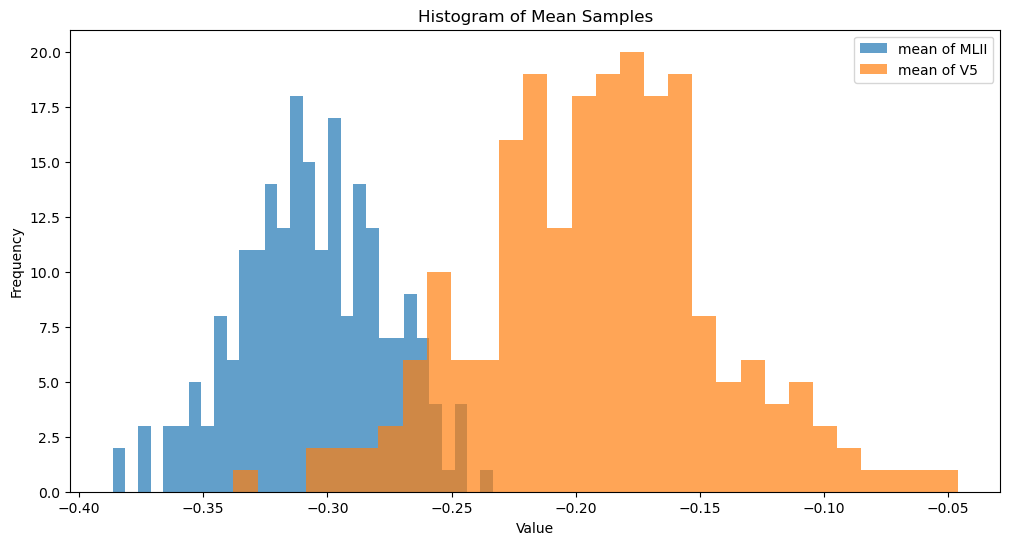

In [10]:
plt.figure(figsize=(12, 6))
plt.hist(mean_samples[:, 0], bins=30, alpha=0.7, label='mean of MLII')
plt.hist(mean_samples[:, 1], bins=30, alpha=0.7, label='mean of V5')
plt.title('Histogram of Mean Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

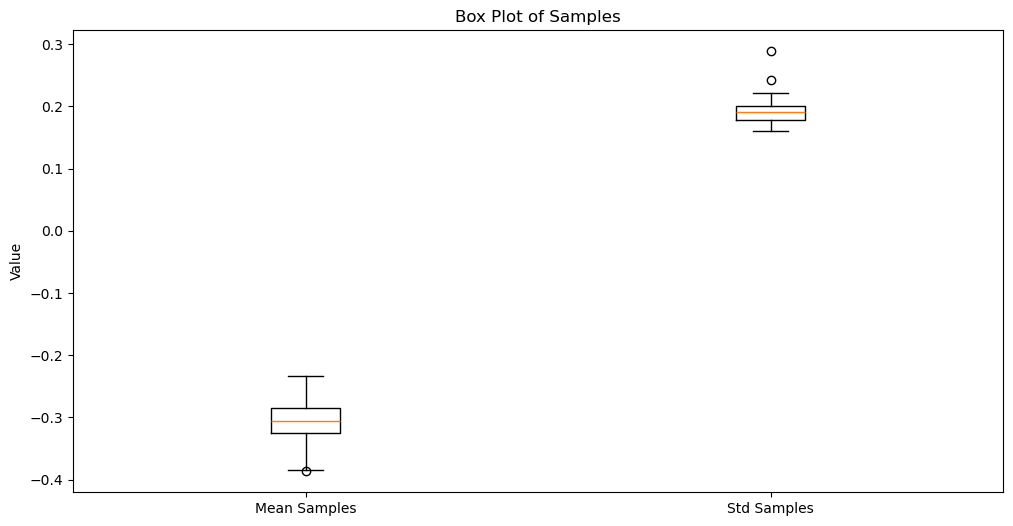

In [11]:
plt.figure(figsize=(12, 6))
plt.boxplot([mean_samples[:, 0], std_samples[:, 0]], tick_labels=['Mean Samples', 'Std Samples'])
plt.title('Box Plot of Samples')
plt.ylabel('Value')
plt.show()

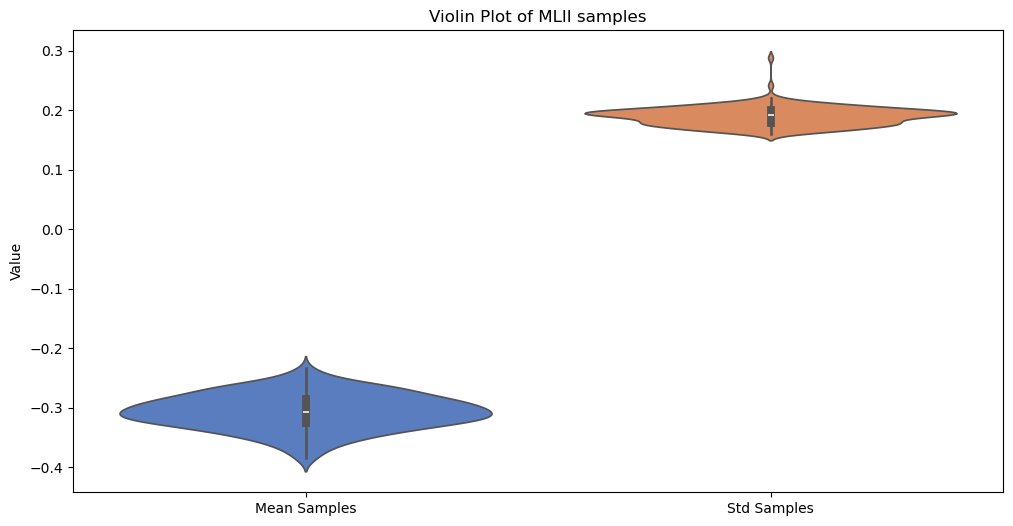

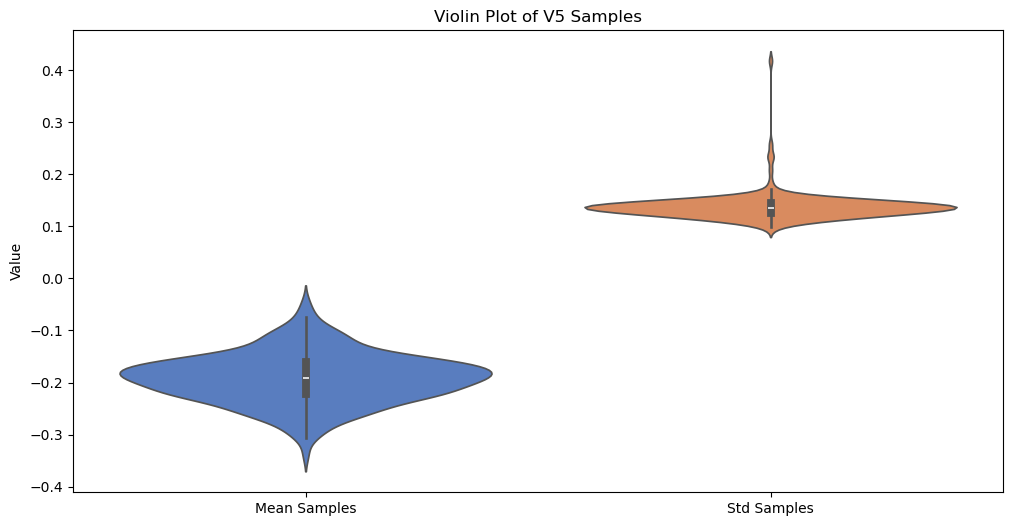

In [12]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=[mean_samples[:,0], std_samples[:,0]], palette='muted')
plt.xticks(ticks=[0, 1], labels=['Mean Samples', 'Std Samples'])
plt.title('Violin Plot of MLII samples')
plt.ylabel('Value')
plt.show()
plt.figure(figsize=(12, 6))
sns.violinplot(data=[mean_samples[:,1], std_samples[:,1]], palette='muted')
plt.xticks(ticks=[0, 1], labels=['Mean Samples', 'Std Samples'])
plt.title('Violin Plot of V5 Samples')
plt.ylabel('Value')
plt.show()

In [13]:
mean_samples.shape

(216, 2)

In [14]:
test = wfdb.rdsamp(os.path.join(root_dir, '100'), sampfrom=0, sampto=3000)[0]
np.mean(test, axis = 0)

array([-0.32352   , -0.20376667])